In [5]:
import os 
import sys
import numpy as np
import pytorch_lightning as L
import torch
sys.path.append("./")
from models.cXVAE import cXVAE_fusedEmbed 
from models.clustering import *
from Data.preprocess import *
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

##!pip install umap-learn
import umap


In [19]:
def plot_umap_latSpace(z, labels_true, labels_conf, modelname="enter modelname"):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(z)
    print(embedding.shape)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.scatter(
        embedding[:,0],
        embedding[:,1],
        c=labels_true,
        cmap="Set2")
    ax2.scatter(
        embedding[:,0],
        embedding[:,1],
        c=labels_conf,
        cmap="Set1")
    plt.gca().set_aspect('equal', 'datalim')
    for ax in [ax1, ax2]:
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
    ax1.set_title("true labels")
    ax2.set_title("confounder labels")
    fig.suptitle(modelname, fontsize=15)
    plt.show()
    return 

In [7]:
''' Set seeds for replicability  -Ensure that all operations are deterministic on GPU (if used) for reproducibility '''
np.random.seed(1234)
torch.manual_seed(1234)
L.seed_everything(1234, workers=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

''' Set PATHs '''
PATH_data = "Data"


''' Load data '''
X1 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_mRNA2_confounded_categ2.csv'), delimiter=",")
X2 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_DNAm_confounded_categ2.csv'), delimiter=",")
X1 = torch.from_numpy(X1).to(torch.float32)
X2 = torch.from_numpy(X2).to(torch.float32)
traits = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_clinic2.csv'), delimiter=",", skiprows=1, usecols=(1,2,3,4,5))
Y = traits[:, -1]

# load artificial confounder
conf_type = 'categ'
conf = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_confounder_categ2.csv'))[:,None]
conf = torch.from_numpy(conf).to(torch.float32)
if conf_type == 'categ':
    conf = torch.nn.functional.one_hot(conf[:,0].to(torch.int64))
print('Shape of confounders:', conf.shape)


#######
X1_test = scale(X1)
X2_test = scale(X2)
conf_test = conf

Global seed set to 1234


Shape of confounders: torch.Size([2547, 6])


## cXVAE

/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.1.post0, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


(2547, 2)


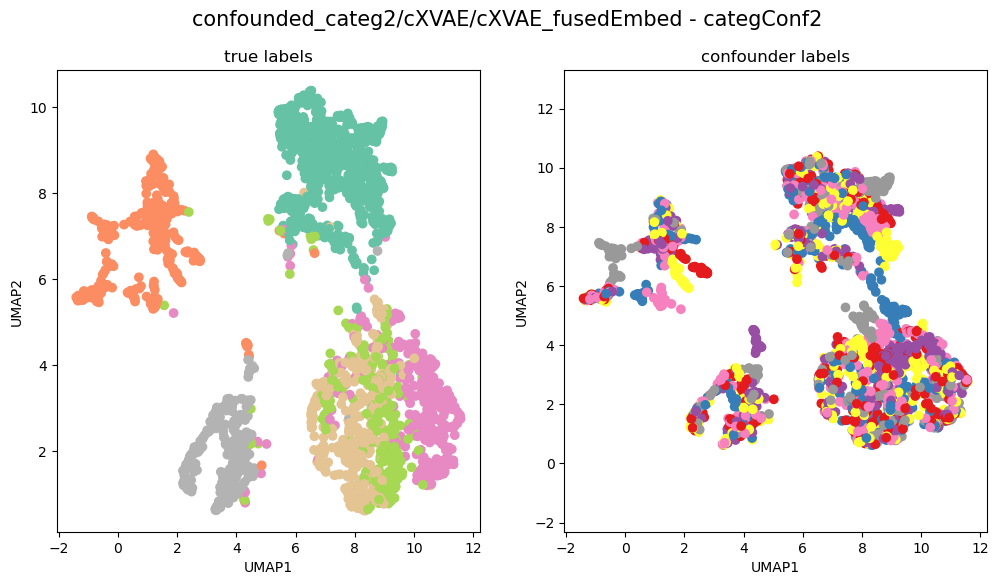

In [11]:
#modelname = 'confounded_categ2/cXVAE/cXVAE_embed'
modelname = 'confounded_categ2/cXVAE/cXVAE_fusedEmbed'
epoch = 150
ckpt_path = f"{os.getcwd()}/lightning_logs/{modelname}/epoch{epoch}/checkpoints"
ckpt_file = f"{ckpt_path}/{os.listdir(ckpt_path)[0]}"


model = cXVAE_fusedEmbed.load_from_checkpoint(ckpt_file)
z = model.generate_embedding(X1_test, X2_test, conf_test).detach().numpy()

conf_orig = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_confounder_categ2.csv'))[:,None]
plot_umap_latSpace(z, Y, conf_orig, modelname=f"{modelname} - categConf2")

## Remove latent features


Dimension latent space - before: (2547, 50)
Dimension latent space - after: (2547, 19)

(2547, 2)


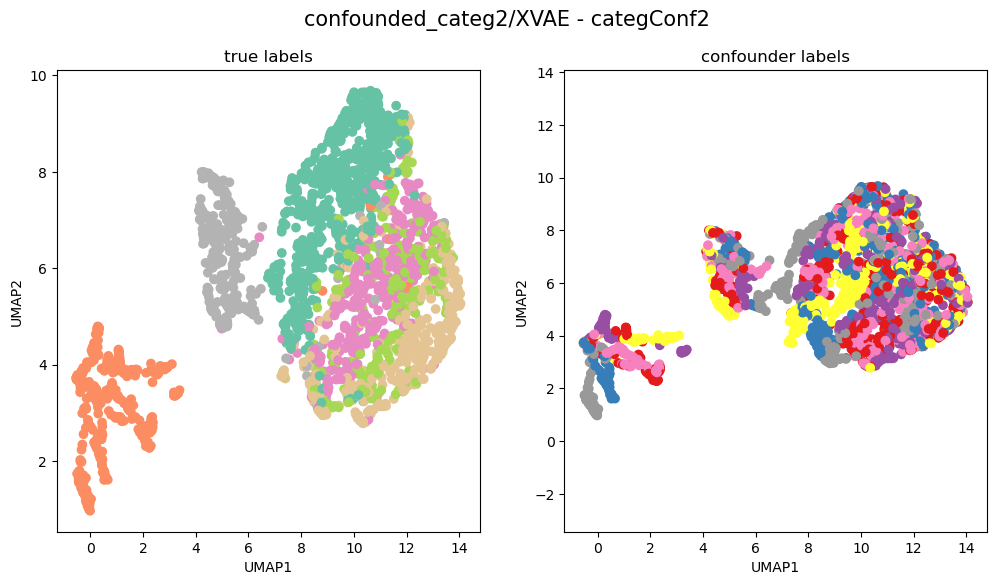

In [22]:
from scipy.stats import pearsonr
from models.XVAE import XVAE

modelname = 'confounded_categ2/XVAE'
epoch = 150
ckpt_path = f"{os.getcwd()}/lightning_logs/{modelname}/epoch{epoch}/checkpoints"
ckpt_file = f"{ckpt_path}/{os.listdir(ckpt_path)[0]}"

model = XVAE.load_from_checkpoint(ckpt_file)
z = model.generate_embedding(X1_test, X2_test).detach().numpy()

print(f"\nDimension latent space - before: {z.shape}")
cutoff_corr = 0.3
#cutoff_pvalue = 0.05
for i in range(conf.shape[1]):
    ## determine correlation of all latFeatures to one confounder variable
    corr = np.array([abs(pearsonr(z[:,j], conf[:,i])[0]) for j in range(z.shape[1])])
    tmp = corr < cutoff_corr
    # corr_pval = np.array([pearsonr(z[:,j], conf[:,i])[1] for j in range(z.shape[1])])
    # tmp = corr_pval > cutoff_pvalue
    if i == 0:
        booleanCorr = tmp.copy()
    else:
        ## combine boolean of all confounders --> only keep completely uncorrelated features
        booleanCorr = np.logical_and(booleanCorr, tmp)
z = z[:,booleanCorr]
print(f"Dimension latent space - after: {z.shape}\n")


#### Plot UMAP

conf_orig = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_confounder_categ2.csv'))[:,None]
plot_umap_latSpace(z, Y, conf_orig, modelname=f"{modelname} - categConf2")

## adversarial training

In [32]:
from models.adversarial_XVAE_multiclass import XVAE, advNet, XVAE_adversarial_multiclass

modelname = "confounded_categ2/XVAE_advTraining/XVAE_advTraining_multiclass"
ls = 50
## pretrainig epochs
epochs_preTrg_ae = 5        #10
epochs_preTrg_advNet = 5    #10
## adversarial training epochs
epochs_ae_w_advNet = 150

ckpt_path = f"{os.getcwd()}/lightning_logs/{modelname}/XVAE_adversarialTrg/epoch{epochs_ae_w_advNet}/checkpoints"
ckpt_file = f"{ckpt_path}/{os.listdir(ckpt_path)[0]}"
ckpt_xvae_path = f"{os.getcwd()}/lightning_logs/{modelname}/pre_XVAE/epoch{epochs_preTrg_ae}/checkpoints"
ckpt_xvae_file = f"{ckpt_xvae_path}/{os.listdir(ckpt_xvae_path)[0]}"
ckpt_advNet_path = f"{os.getcwd()}/lightning_logs/{modelname}/pre_advNet/epoch{epochs_preTrg_advNet}/checkpoints"
ckpt_advNet_file = f"{ckpt_advNet_path}/{os.listdir(ckpt_advNet_path)[0]}"

model = XVAE_adversarial_multiclass.load_from_checkpoint(ckpt_file,
            PATH_xvae_ckpt=ckpt_xvae_file, PATH_advNet_ckpt=ckpt_advNet_file)

z = model.xvae.generate_embedding(X1_test, X2_test).detach().numpy()

(2547, 2)


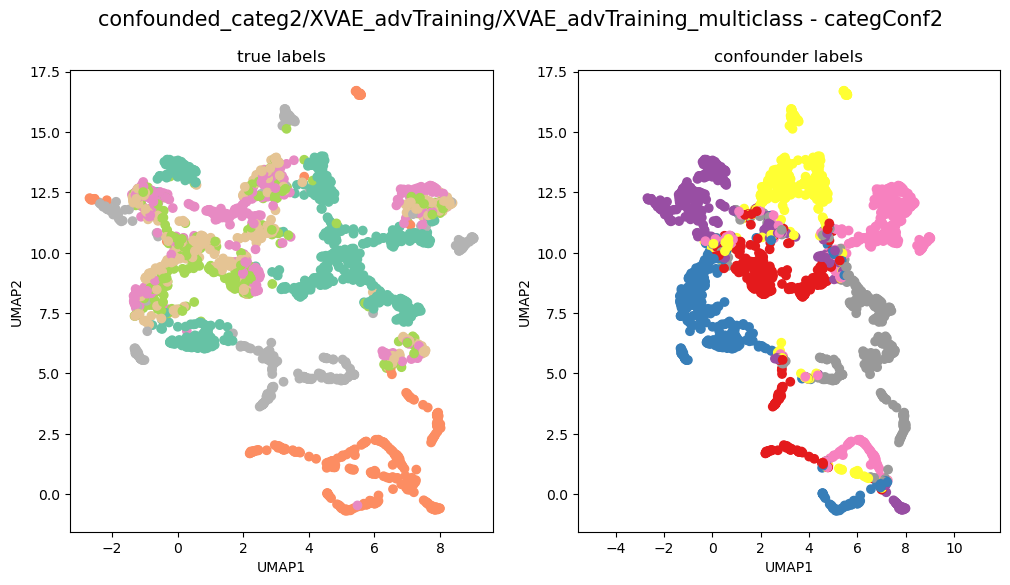

In [35]:
conf_orig = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_confounder_categ2.csv'))[:,None]
plot_umap_latSpace(z, Y, conf_orig, modelname=f"{modelname} - categConf2")